In [1]:
%autoreload 2

In [19]:
from argparse import Namespace
from collections import defaultdict
import dataclasses
import copy
import glob
import gzip
import os
import pickle
import sys
import time
import typing
import re

from IPython.display import display, Markdown, Latex
import numpy as np
import pandas as pd
import tatsu
import tatsu.exceptions
import tqdm.notebook as tqdm
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../src'))
from src.ast_utils import load_games_from_file, _extract_game_id
from ast_counter_sampler import *

In [22]:
game_texts = list(load_games_from_file('../dsl/interactive-beta.pddl'))
game_texts_by_id = {_extract_game_id(text): text for text in game_texts}
game_ids = list(game_texts_by_id.keys())

In [4]:
augmentation_results_by_seed = {}

for augmentations_output_path in glob.glob('../dsl/codex/codex_augmentations_seed_*.pkl.gz'):
    print(augmentations_output_path)
    seed = int(augmentations_output_path[augmentations_output_path.rindex('_') + 1:-7])
    with gzip.open(augmentations_output_path, 'rb') as f:
        augmentation_results_by_seed[seed] = pickle.load(f)

print(augmentation_results_by_seed.keys())


../dsl/codex/codex_augmentations_seed_7.pkl.gz
../dsl/codex/codex_augmentations_seed_13.pkl.gz
../dsl/codex/codex_augmentations_seed_23.pkl.gz
../dsl/codex/codex_augmentations_seed_33.pkl.gz
../dsl/codex/codex_augmentations_seed_42.pkl.gz
dict_keys([7, 13, 23, 33, 42])


In [5]:
GAME_ID_KEYS = ('game_index', 'game_id')
SECTION_INDICES_KEYS = ('before_indices', 'after_indices')
WHITESPACE_PATTERN = re.compile(r'\s+')


def LCS(s1: str, s2: str) -> typing.Tuple[int, int]:
    m = np.zeros((len(s1) + 1, len(s2) + 1), dtype=int)
    longest, x_longest = 0, 0
    for x in range(1, 1 + len(s1)):
        for y in range(1, 1 + len(s2)):
            if s1[x - 1] == s2[y - 1]:
                m[x][y] = m[x - 1][y - 1] + 1
                if m[x][y] > longest:
                    longest = m[x][y]
                    x_longest = x
            else:
                m[x][y] = 0
                
    return x_longest - longest, longest


def game_results_to_rows(game_results: typing.Dict[str, typing.Any]) -> typing.List[typing.Dict[str, typing.Any]]:
    rows = []
    row_template = {k: game_results[k] for k in GAME_ID_KEYS}
    row = {}
    for k, v in game_results.items():
        if k in GAME_ID_KEYS:
            continue

        prompt = WHITESPACE_PATTERN.sub(' ', v['prompt']).strip()

        section_row_template = copy.copy(row_template)
        section_row_template['section'] = k.replace('(:', '')
        section_row_template.update({k: v for k, v in v.items() if k in SECTION_INDICES_KEYS})

        for i, choice in enumerate(v['results']['choices']):
            completion = WHITESPACE_PATTERN.sub(' ', choice.text).strip()
            lcs_start, lcs_length = LCS(completion, prompt)

            row = copy.copy(section_row_template)
            row['completion_index'] = i
            row['completion'] = completion
            row['lcs_start'] = lcs_start
            row['lcs_length'] = lcs_length
            row['lcs_percent'] = lcs_length / len(completion) if len(completion) > 0 else 0
            rows.append(row)
            
    return rows


def seed_results_to_rows(seed_results: typing.List[typing.Dict[str, typing.Any]]) -> typing.List[typing.Dict[str, typing.Any]]:
    rows = []
    for game_results in tqdm.tqdm(seed_results):
        rows.extend(game_results_to_rows(game_results))
    return rows


def all_results_to_df(results: typing.Dict[int, typing.List[typing.Dict[str, typing.Any]]]):
    rows = []
    for seed, seed_results in results.items():
        seed_rows = seed_results_to_rows(seed_results)
        for row in seed_rows:
            row['seed'] = seed 
        rows.extend(seed_rows)

    return pd.DataFrame(rows)


In [39]:
PARSE_DATA = False
SAVE_PATH = '../dsl/codex/codex_augmentations_df.csv'

if PARSE_DATA:
    df = all_results_to_df(augmentation_results_by_seed)
else:
    df = pd.read_csv(SAVE_PATH)

df.head()

,game_index,game_id,section,before_indices,after_indices,completion_index,completion,lcs_start,lcs_length,lcs_percent,seed,key
0,0,6172feb1665491d1efbce164-0,setup,[59 63 89],[58 95],0,(and (exists (?b - ball ?h - hexagonal_bin) (o...,19,23,0.159722,7,7.6172feb1665491d1efbce164-0.setup.0
1,0,6172feb1665491d1efbce164-0,setup,[59 63 89],[58 95],1,(and (exists (?b - basketball) (game-conserved...,29,19,0.296875,7,7.6172feb1665491d1efbce164-0.setup.1
2,0,6172feb1665491d1efbce164-0,setup,[59 63 89],[58 95],2,(and (exists (?b - ball ?r - triangular_ramp ?...,63,38,0.128814,7,7.6172feb1665491d1efbce164-0.setup.2
3,0,6172feb1665491d1efbce164-0,constraints,[ 1 27 28],[88 83],0,(and (preference throwToRampToBin (exists (?b ...,342,119,0.258134,7,7.6172feb1665491d1efbce164-0.constraints.0
4,0,6172feb1665491d1efbce164-0,constraints,[ 1 27 28],[88 83],1,(and (forall (?b - (either dodgeball golfball)...,220,198,0.473684,7,7.6172feb1665491d1efbce164-0.constraints.1


## Running some statistics

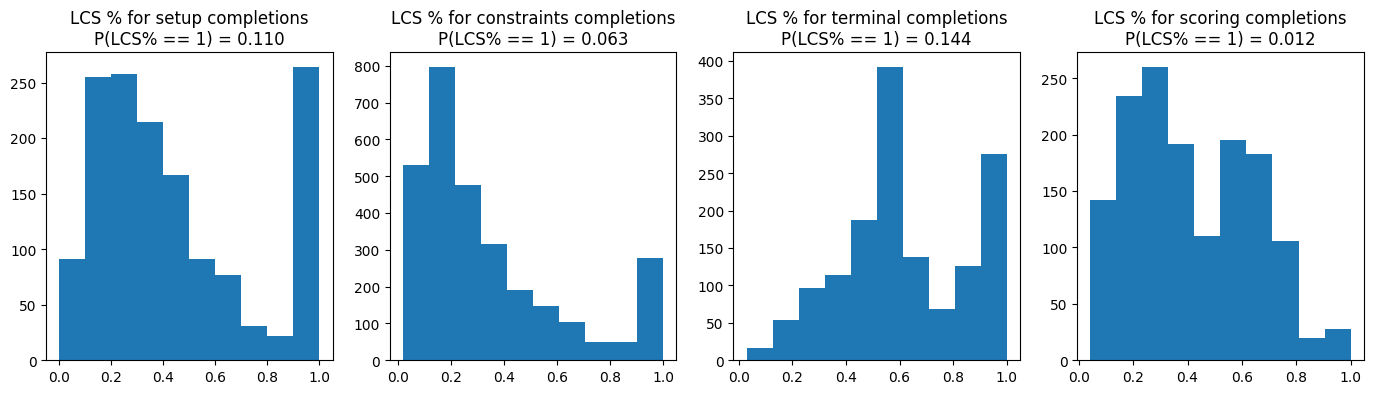

In [7]:
fig, axes = plt.subplots(1, 4, figsize=(17, 4))

for i, section, in enumerate(df.section.unique()):
    ax = axes[i]
    section_data = df[df.section == section].lcs_percent
    ax.hist(section_data)
    ax.set_title(f'LCS % for {section} completions\nP(LCS% == 1) = {(section_data == 1).sum() / len(section_data):.3f}')


plt.show()



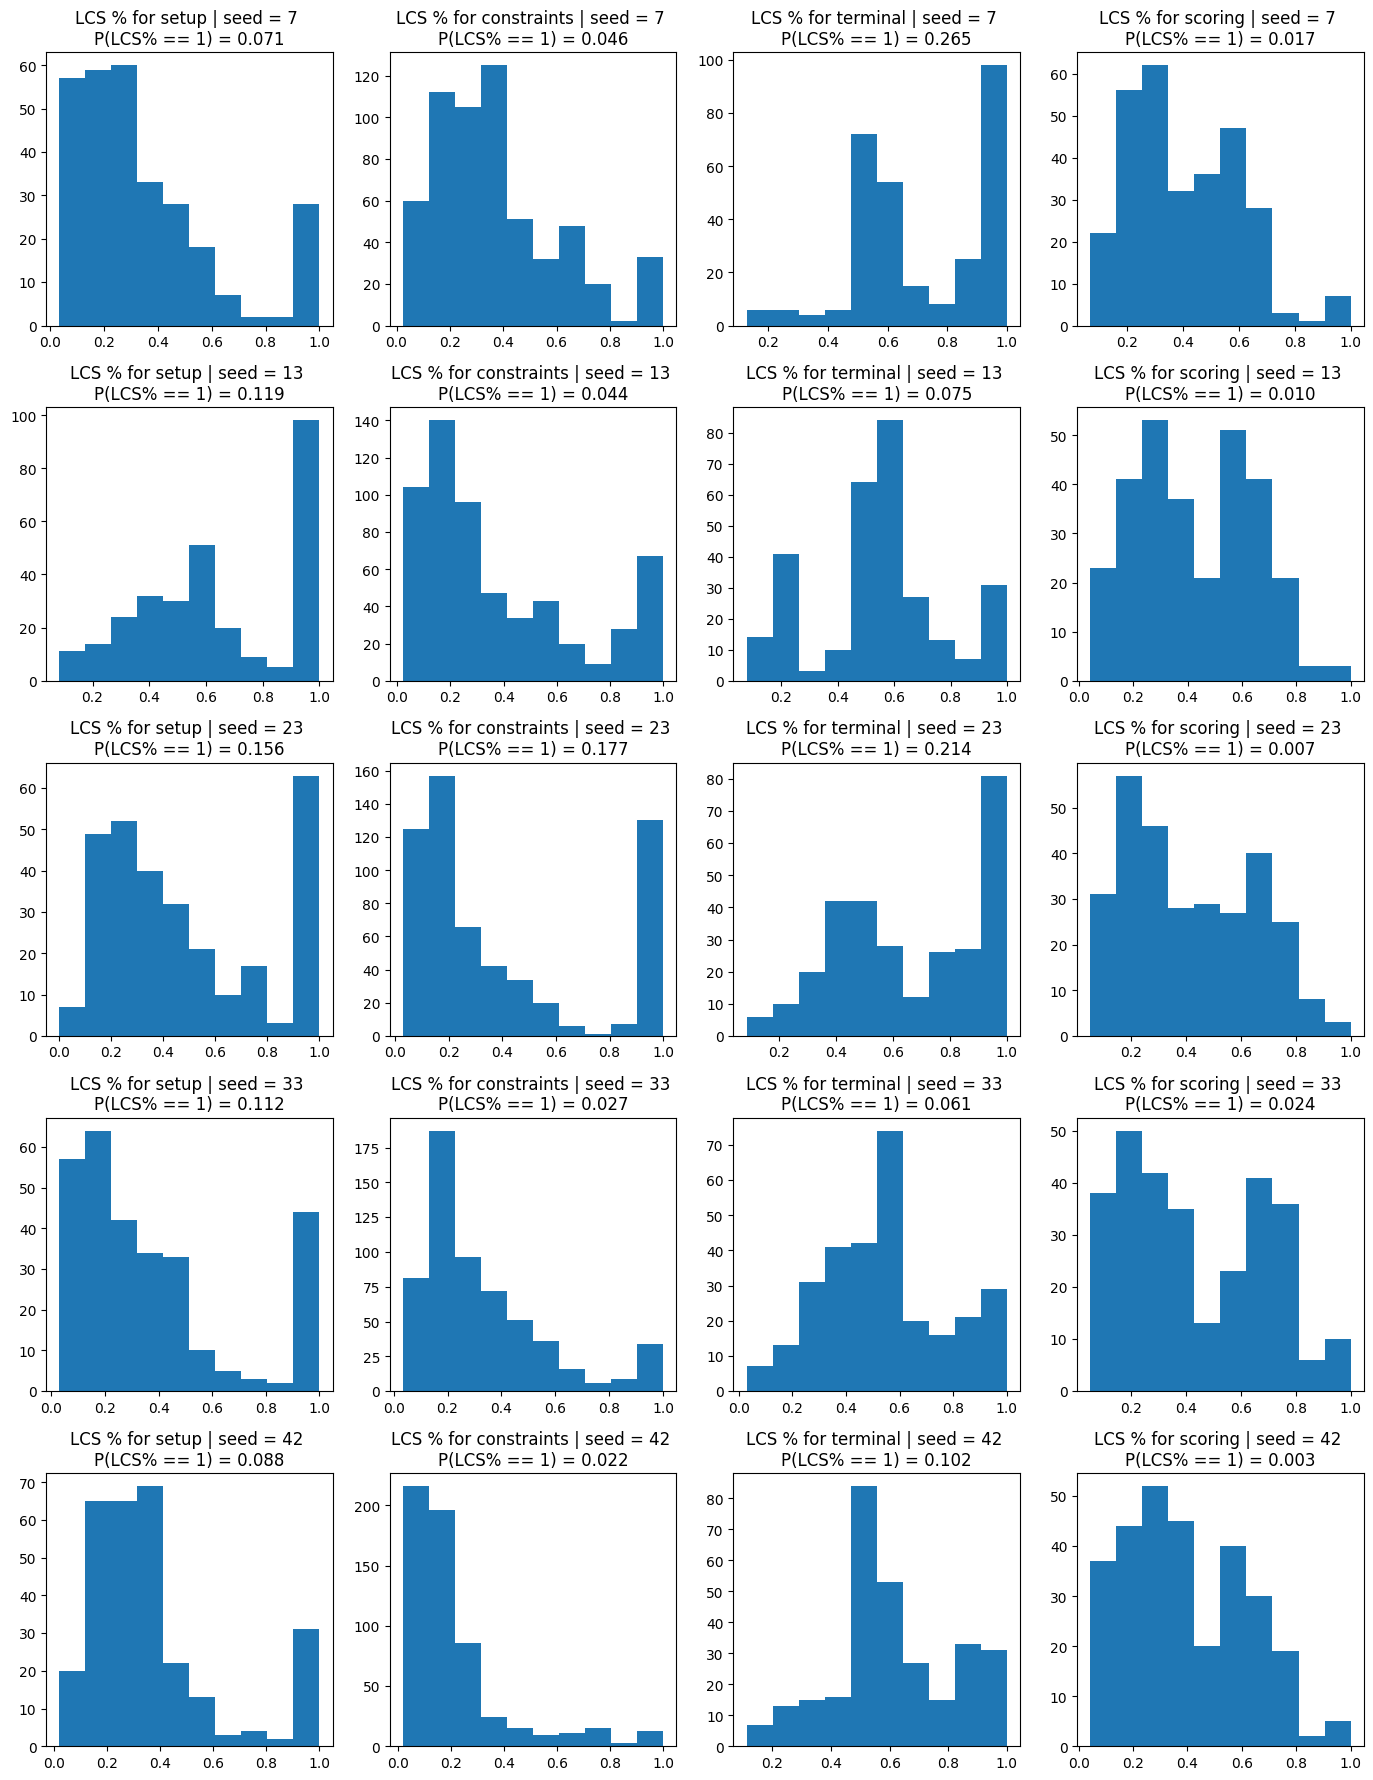

In [8]:
fig, axes = plt.subplots(5, 4, figsize=(17, 22))

for s, seed in enumerate(df.seed.unique()):
    for i, section, in enumerate(df.section.unique()):
        ax = axes[s][i]
        section_data = df[np.logical_and(df.section == section, df.seed == seed)].lcs_percent
        ax.hist(section_data)
        ax.set_title(f'LCS % for {section} | seed = {seed} \nP(LCS% == 1) = {(section_data == 1).sum() / len(section_data):.3f}')

plt.subplots_adjust(hspace=0.3)
plt.show()



In [9]:
before_index_to_lcs = defaultdict(lambda: defaultdict(list))
after_index_to_lcs = defaultdict(lambda: defaultdict(list))

for i, row in df.iterrows():
    for before_index in row.before_indices:
        before_index_to_lcs[before_index][row.section].append(row.lcs_percent)
    
    for after_index in row.after_indices:
        after_index_to_lcs[after_index][row.section].append(row.lcs_percent)

/Users/guydavidson/opt/anaconda3/envs/game-gen/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/guydavidson/opt/anaconda3/envs/game-gen/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


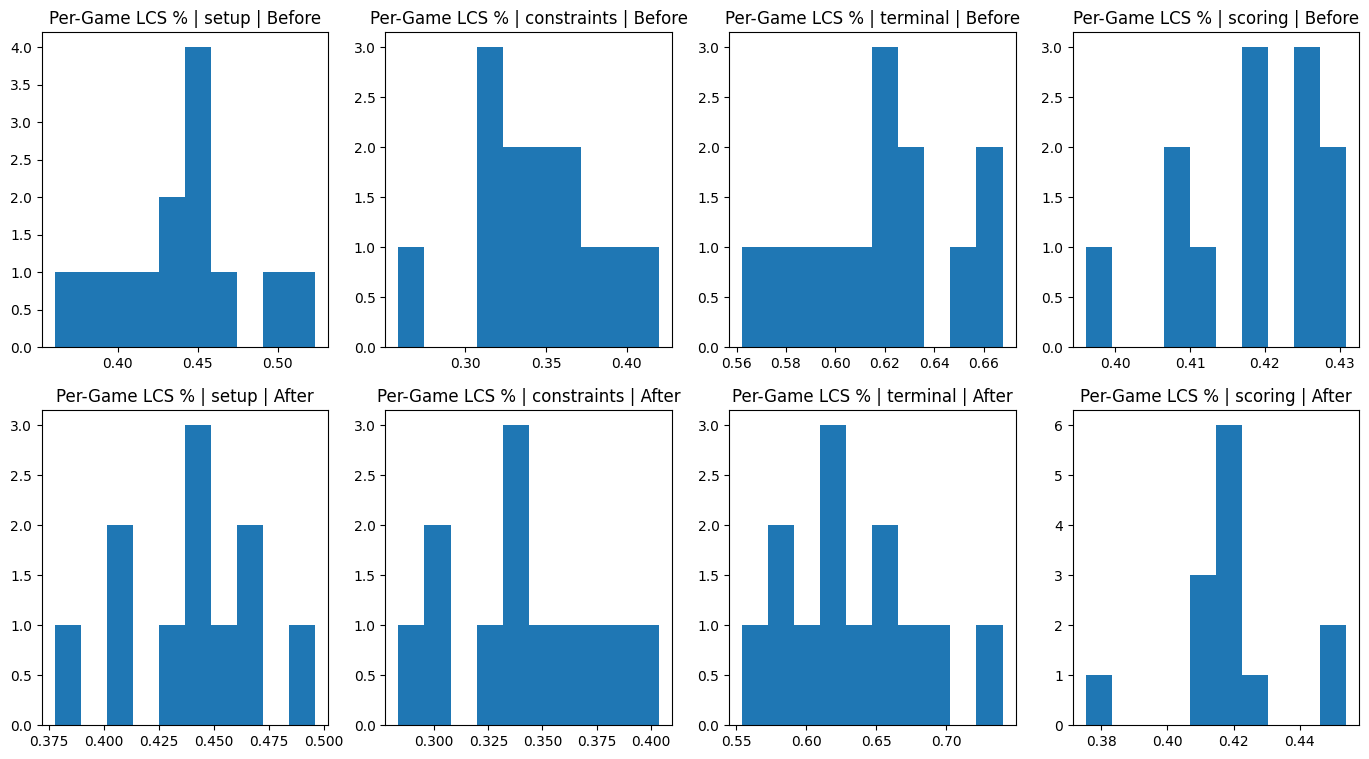

In [10]:
fig, axes = plt.subplots(2, 4, figsize=(17, 9))

for i, section, in enumerate(df.section.unique()):
    before_ax = axes[0][i]
    before_data_per_seed = [np.mean(before_index_to_lcs[index][section]) for index in before_index_to_lcs.keys()]
    before_ax.hist(before_data_per_seed)
    before_ax.set_title(f'Per-Game LCS % | {section} | Before')

    after_ax = axes[1][i]
    after_data_per_seed = [np.mean(after_index_to_lcs[index][section]) for index in after_index_to_lcs.keys()]
    after_ax.hist(after_data_per_seed)
    after_ax.set_title(f'Per-Game LCS % | {section} | After')


# plt.subplots_adjust(wspace=)
plt.show()



## Validating samples

In [31]:
args = Namespace(
    parse_counter=False, 
    counter_output_path=os.path.join('..', DEFAULT_COUNTER_OUTPUT_PATH),
    grammar_file=os.path.join('..', DEFAULT_GRAMMAR_FILE),
    random_seed=RANDOM_SEED,
    test_files=['../dsl/interactive-beta.pddl'],
    dont_tqdm=False,
    validate_samples=True, 
    save_samples=True,
    print_samples=False
    
)

grammar = open(args.grammar_file).read()
grammar_parser = tatsu.compile(grammar)

In [70]:
SECTION_KEYS_TO_TEMPLATES = {
    'setup': '(:setup',
    'constraints': '(:constraints',
    'terminal': '(:terminal',
    'scoring': '(:scoring',
}
SECTION_SUFFIX = ')\n'

MINIMAL_GAME_PREFIX = '(define (game 57aa430b4cda6e00018420e9-10) (:domain medium-objects-room-v1)'
MINIMAL_GAME_COMPONENTS = {
    'setup': '''(:setup (and 
    (exists (?h - hexagonal_bin)
        (game-conserved (< (distance ?h room_center) 1))
    )
))''',
    'constraints': '''(:constraints (and 
    (preference throwTeddyOntoPillow
        (exists (?t - teddy_bear ?p - pillow)
            (then 
                (once (agent_holds ?t))
                (hold (and (not (agent_holds ?t)) (in_motion ?t))) 
                (once (and (not (in_motion ?t)) (on ?p ?t)))
            )
        )
    )
    (preference throwAttempt
        (exists (?t - teddy_bear)
            (then 
                (once (agent_holds ?t))
                (hold (and (not (agent_holds ?t)) (in_motion ?t))) 
                (once (not (in_motion ?t)))
            )
        )
    )
))''',
    'terminal': '''(:terminal
    (>= (count throwAttempt) 10)
)''',
    'scoring': '''(:scoring (count throwTeddyOntoPillow)
))''',
}


grammatical = []


def _game_from_row_completion(row):
    game = MINIMAL_GAME_PREFIX[:]
    for section in MINIMAL_GAME_COMPONENTS:
        if section == row.section:
            completion = f'{SECTION_KEYS_TO_TEMPLATES[section]} {row.completion}'
            open_count = completion.count('(')
            while open_count > completion.count(')'):
                completion += SECTION_SUFFIX

        else:
            completion = MINIMAL_GAME_COMPONENTS[section]

        game += '\n' + completion

    game_open_count = game.count('(')
    while game_open_count > game.count(')'):
        game += SECTION_SUFFIX

    return game


for i, row in tqdm.tqdm(df.iterrows(), total=df.shape[0]):
    game = _game_from_row_completion(row)

    try:
        game_ast = grammar_parser.parse(game)    
        grammatical.append(True)

    except tatsu.exceptions.FailedParse:
        # print(f'Failed to parse game with {row.key}')
        grammatical.append(False)
        continue


# df = df.assign(grammatical=grammatical)



100%|██████████| 7350/7350 [05:43<00:00, 21.39it/s]


In [73]:
df.grammatical.mean()

0.9106122448979592

In [127]:
i = 49
row = df[~df.grammatical].iloc[i]
print(row.section, ':')
print(row.completion)

scoring :
(+ (count ballThrownToRampToBed) (* -2 (count ballThrownHitsAgent)) )))


## Codex grammar mistake examples:
* Generic:
    * Changing/hallucinating object names/types (`dog_bed` instead of `doggie_bed`, `card_table`,)
    * Hallucinating predicdates (`moveable`, `toggled_off` (`toggled_on` does exist), `drawer_closed`, `drawer_open` (we call it `open`) )
    * Predicate arity mistakes (mostly with `adjacent_side` which has variable arity, but also once with `adjacent`)
    * Writing a negative number as `-10` instead of `(- 10)`
    * Too many close parentheses -- easily fixable
* Setup: 
    * Forgetting a `(game-optional)` or `(game-conserved)`
* Preferences:
    * Getting the forall over preferences syntax wrong -- naming preferences like `throwToDrawerOrBin:?b` or `throwToDrawerOrBin:?b:?h` or `throwToDrawerOrBin:golfball:top_drawer`
    * Putting a predicate outside a conjunction: `(hold (and (not (agent_holds ?d)) (in_motion ?d)) (not (touch ?c ?d)))` -- this would work in a `(hold-while)` (and mean something different), but not in a regular hold.
    * Weird quantification mistakes:
        * Empty quantification: `(preference ballInMotion (exists () (then ...)`
        * Two separate parentheses: `(preference throwObjectToTarget (exists (?b - (either book dodgeball)) (?h - hexagonal_bin ?d - doggie_bed) (then ...)`
        * A double/nested either: `(preference turnOffObjects (exists (?s - (either (either main_light_switch desktop) book)) (then ...)`
    * Codex attempting to write an infinite loop? `(then (once (in top_drawer ?g)) (hold true) ) )`
    * Using the setup `(game-conserved)` operator in a preference: `(preference gameConserved (exists (?b - (either book dodgeball)) (game-conserved ...)`
    * This fascinating mistake: `(preference wallNotOpposite (not (preference wallOpposite))`
    * Forgetting to conjunct predicates inside a `(not)`: ` (not (same_type ?g bridge_block) (adjacent ?w1 ?g) )`
* Terminal conditions:
    * Predicates in terminal
    * Comparison without a second argument
    * Operators with the wrong arity (putting three terms inside a minus operator)
    * Forgetting to conjunct over multiple terms `(>= (count throwBallToBin:dodgeball) 2) (>= (count throwBallToBin:basketball) 2) (>= (count throwBallToBin:beachball) 2)`
    * This amusing thing: `(or (game_over) (>= (count ballThrownToWallToAgent) 3))` -- the terminal conditions are supposed to define when the game is over...
* Scoring:
    * Predicates in scoring
    * Scoring without any operators: `(total-time) (total-score) ))`
    * Hallucinating scoring operators: `(* 3 (count-per-external-objects throwAttempt))`


In [128]:
RANDOM_SEED = 33

SECTION_KEYS_TO_TEMPLATES = {
    'setup': '(:setup',
    'constraints': '(:constraints',
    'terminal': '(:terminal',
    'scoring': '(:scoring',
}
GAME_TEMPLATE = '(define (game {game_id}) (:domain {domain})'
SECTION_SUFFIX = ')\n'


def _extract_domain(game_text: str, key: str = '(:domain'):
    start_index = game_text.index(key) + len(key) + 1
    return game_text[start_index: game_text.index(')', start_index)]


def _sample_game_section(game_df: pd.DataFrame, section_name: str, 
    section_flag: typing.Union[str, int], rng: np.random.Generator):
    section_df = game_df[game_df.section == section_name]
    if section_flag is True:
        section_flag = rng.integers(section_df.shape[0] - 1)

    if not isinstance(section_flag, bool):
        return section_df.loc[section_df.index[section_flag], 'completion'], section_flag


def combine_game_from_single_game(augmentations_df: pd.DataFrame,
    game_texts_by_id: typing.Dict[str, str],
    game_id: str, 
    sample_id: typing.Union[str, int],
    setup: typing.Union[bool, int],
    preferences: typing.Union[bool, int],
    terminal: typing.Union[bool, int],
    scoring: typing.Union[bool, int],
    rng: typing.Optional[np.random.Generator] = None,
    random_seed: int = RANDOM_SEED,
    sample_name: typing.Optional[str] = None, 
    ):

    if preferences is False or scoring is False:
        raise ValueError('Cannot sample a game without preferences or scoring')

    if rng is None:
        rng = np.random.default_rng(seed=random_seed)

    game_df = df[np.logical_and(df.game_id == game_id, df.grammatical)]
    game_text = game_texts_by_id[game_id]

    game_id_components = [game_id]
    if sample_name is not None:
        game_id_components.append(sample_name)
    game_id_components.append(str(sample_id))

    updated_game_id = '-'.join(game_id_components)
    domain_name = _extract_domain(game_text)

    game = GAME_TEMPLATE.format(game_id=updated_game_id, domain=domain_name)
    sample_indices = {}

    for key, flag in zip(SECTION_KEYS_TO_TEMPLATES.keys(), (setup, preferences, terminal, scoring)):
        section_sample = _sample_game_section(game_df, key, flag, rng)
        if section_sample is not None:
            section_sample, sample_index  = section_sample
            sample_indices[key] = sample_index

            section_sample = f'{SECTION_KEYS_TO_TEMPLATES[key]} {section_sample}'
            open_count = section_sample.count('(')
            while open_count > section_sample.count(')'):
                section_sample += SECTION_SUFFIX

            game += '\n' + section_sample
    
    while game.count('(') > game.count(')'):
        game += SECTION_SUFFIX

    return game, sample_indices





In [129]:
N_GAMES_PER_ORIGINAL_GAME = 10
rng = np.random.default_rng(seed=args.random_seed)
game_texts = []
index_success_counts = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))
index_failure_counts = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))

for game_id in tqdm.tqdm(game_ids):
    for i in range(N_GAMES_PER_ORIGINAL_GAME):
        game, sample_indices = combine_game_from_single_game(df, game_texts_by_id, game_id, i, 
            True, True, True, True, rng=rng, sample_name='codex-combine')
        
        try:
            game_ast = grammar_parser.parse(game)
            game_text = test_ast_sample(game_ast, args, grammar_parser)
            game_texts.append(game_text)
            for section, index in sample_indices.items():
                index_success_counts[game_id][section][index] += 1

        except tatsu.exceptions.FailedParse:
            for section, index in sample_indices.items():
                index_failure_counts[game_id][section][index] += 1

            continue




100%|██████████| 98/98 [02:16<00:00,  1.40s/it]


In [131]:
for game_id, game_data in index_failure_counts.items():
    for section, section_data in game_data.items():
        for index, count in section_data.items():
            if count > 0:
                # if index not in index_success_counts[game_id][section] or index_success_counts[game_id][section][index] == 0:
                print(f'{game_id}: {section} #{index} failed {count} times and never succeeded')

In [136]:
for game_text in tqdm.tqdm(game_texts):
    game_ast = grammar_parser.parse(game_text)
    test_ast_sample(game_ast, args, grammar_parser)

100%|██████████| 980/980 [02:13<00:00,  7.36it/s]


In [134]:
with open('../dsl/ast-codex-combine-samples.pddl', 'w') as out:
    out.write('\n\n'.join(game_texts))

In [142]:
single_game_results_by_seed = {}

for single_game_output_path in glob.glob('../dsl/codex/codex_single_game_iterative_seed_*.pkl.gz'):
    print(single_game_output_path)
    seed = int(single_game_output_path[single_game_output_path.rindex('_') + 1:-7])
    with gzip.open(single_game_output_path, 'rb') as f:
        single_game_results_by_seed[seed] = pickle.load(f)

print(single_game_results_by_seed.keys())



../dsl/codex/codex_single_game_iterative_seed_55.pkl.gz
../dsl/codex/codex_single_game_iterative_seed_88.pkl.gz
../dsl/codex/codex_single_game_iterative_seed_77.pkl.gz
../dsl/codex/codex_single_game_iterative_seed_13.pkl.gz
../dsl/codex/codex_single_game_iterative_seed_66.pkl.gz
../dsl/codex/codex_single_game_iterative_seed_42.pkl.gz
../dsl/codex/codex_single_game_iterative_seed_33.pkl.gz
../dsl/codex/codex_single_game_iterative_seed_23.pkl.gz
dict_keys([55, 88, 77, 13, 66, 42, 33, 23])


In [144]:
success_count_by_seed = defaultdict(int)

for seed, seed_results in single_game_results_by_seed.items():
    for game_result in tqdm.tqdm(seed_results):
        game = game_result['final_generation']

        try:
            game_ast = grammar_parser.parse(game)
            game_text = test_ast_sample(game_ast, args, grammar_parser)
            success_count_by_seed[seed] += 1

        except:
            continue

print(success_count_by_seed)


100%|██████████| 98/98 [00:06<00:00, 14.18it/s]

defaultdict(<class 'int'>, {55: 9, 88: 9, 77: 8, 13: 22, 66: 11, 42: 7, 33: 7, 23: 16})
